# Backward demostration

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

np.set_printoptions(suppress=True, precision=3)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history
from connectivity_functions import artificial_connectivity_matrix

from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation

# The example

In [70]:
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 15
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'a', 'z_pre_ampa', 'w_ampa']


# Build the network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

Tp = 0.050
factor = tau_a * np.log(2.0 - np.exp(-Tp/tau_a))
Tc  = Tp + factor
Tn = Tc + 0.010  # Fails for this
Tn = 3.0
index_p = 5
training_time = [Tp for i in range(n_patterns)]
#training_time[5] = Tc + 0.010 + 0.500
training_time[index_p] = Tn

#nn.w_ampa = w_timed
print(training_time)
print(factor)
print('Tc', Tc)

[0.05, 0.05, 0.05, 0.05, 0.05, 3.0, 0.05, 0.05, 0.05, 0.05]
0.0416473733459
Tc 0.0916473733459


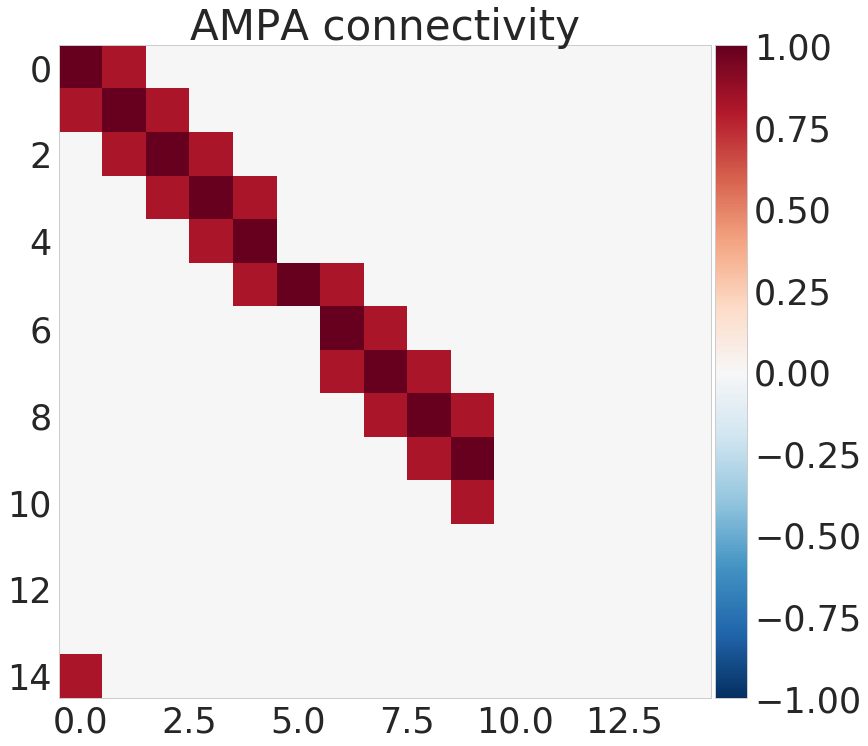

In [71]:
w_rest = 0.0
w_self = 1.0
w_next = []
symmetric = False
free_atractor = False

for T in training_time:
    w_diff = 1 - np.exp(- T/ tau_a)
    w_next.append(w_self - w_diff)
w = np.ones((minicolumns, minicolumns)) * w_rest
for i in range(n_patterns):
    w[i, i] = w_self
    if i < minicolumns - 1:
        w[i + 1, i] = w_next[i]
        w[i - 1, i] = w_next[i]


if symmetric:
    w[index_p - 1, index_p] = w_next[1]
else:
    w[index_p - 1, index_p] = 10e-14
if free_atractor:
    w[index_p + 1, index_p] = -0.1

nn.w_ampa = w
plot_weight_matrix(manager.nn, ampa=True)

100.0


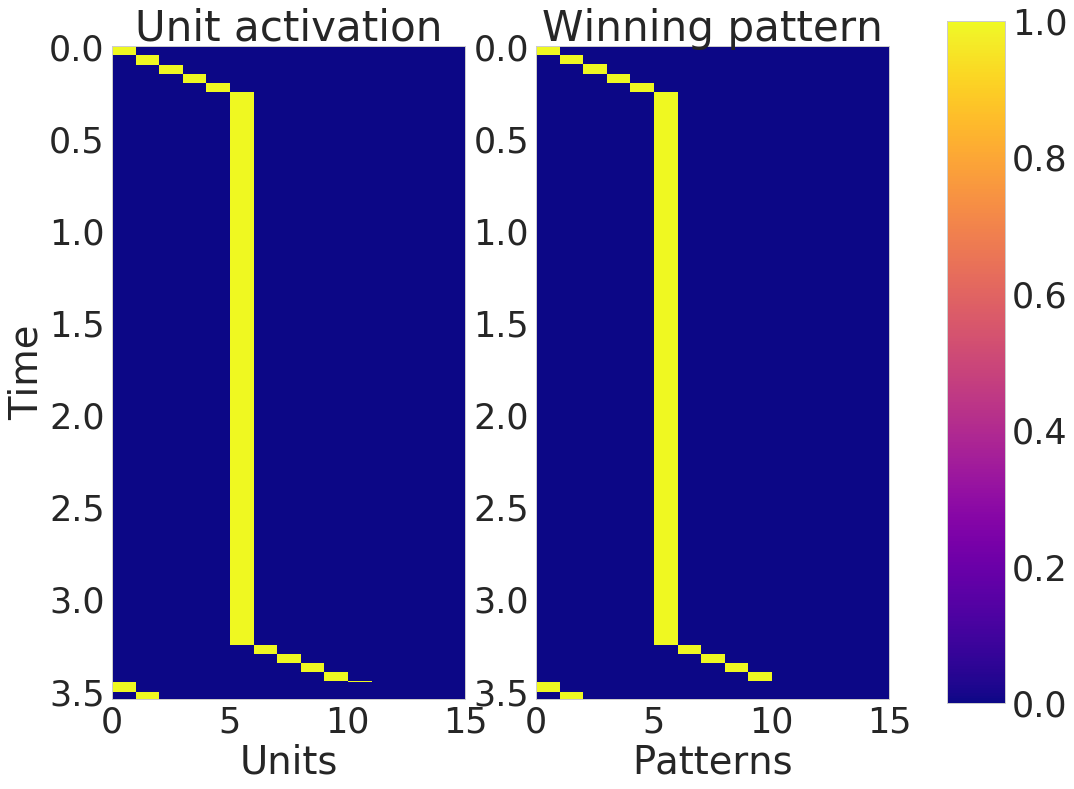

In [72]:
T_cue = 0.020
T_recall = Tn + Tp * n_patterns +  T_cue

patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux
plot_network_activity_angle(manager)
print(success)

# Systematic

#### Perfect case

In [7]:
%%time
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Training times
Tp = 0.100
factor = tau_a * np.log(2.0 - np.exp(-Tp/tau_a))
Tc = Tp + factor

num = 30
Tn_space = np.linspace(Tp, Tc + 0.050, num=num)
successes = np.zeros(num)

# Matrix parameters
w_rest = -1.0
w_self = 1.0
w_next = []
symmetric = True
index_p = 5

# Recall
patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

training_time = [Tp for i in range(n_patterns)]

for index, Tn in enumerate(Tn_space):
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    training_time[index_p] = Tn
    # Print
    
    # Build the matrix
    w_next = []
    for T in training_time:
        w_diff = 1 - np.exp(- T/ tau_a)
        w_next.append(w_self - w_diff)
    w = np.ones((minicolumns, minicolumns)) * w_rest
    for i in range(n_patterns):
        w[i, i] = w_self
        if i < minicolumns - 1:
            w[i + 1, i] = w_next[i]
            w[i - 1, i] = w_next[i]
    
    # Symmetric
    if symmetric:
        w[index_p - 1, index_p] = w_next[1]
    else:
        w[index_p - 1, index_p] = 10e-10
    
    # Add the matrix
    nn.w_ampa = w
    
    # Run the network
    T_cue = 0.020
    T_recall = Tn + Tp * n_patterns +  T_cue
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    successes[index] = success

CPU times: user 9.97 s, sys: 40 ms, total: 10 s
Wall time: 10 s


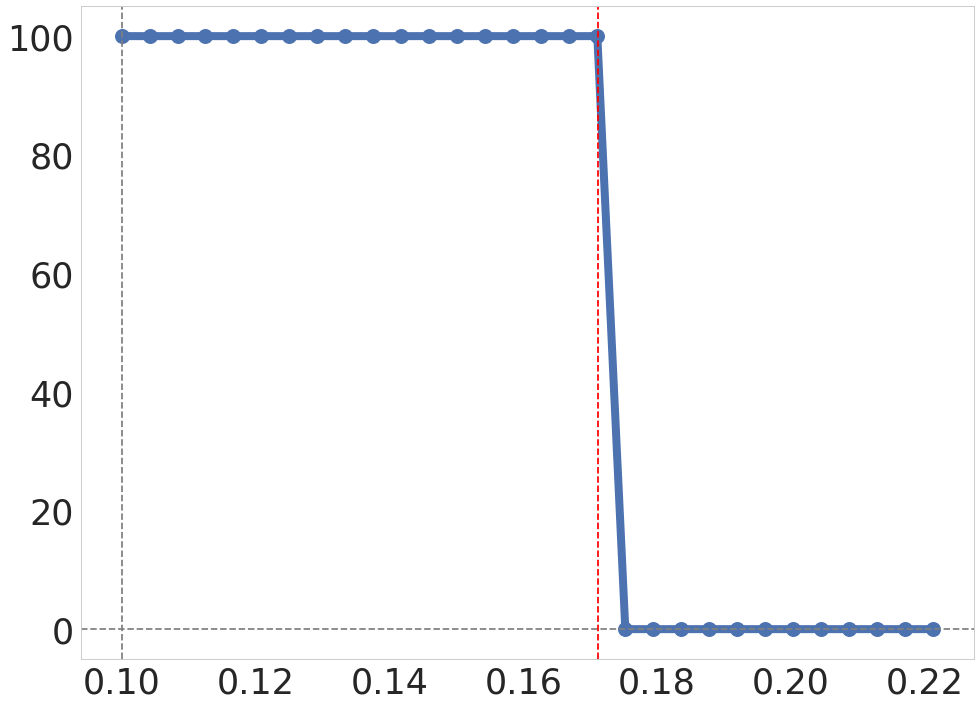

In [8]:
markersize = 15
linewidth = 3

plt.plot(Tn_space, successes, 'o-', markersize=markersize, lw=linewidth)
plt.axhline(0, ls='--', color='gray')
plt.axvline(Tp, ls='--', color='gray')
plt.axvline(Tc, ls='--', color='red')

#### Asymmetric case

In [76]:
%%time
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Training times
Tp = 0.100
factor = tau_a * np.log(2.0 - np.exp(-Tp/tau_a))
Tc = Tp + factor

num = 30
Tn_space = np.linspace(Tp, Tc + 0.050, num=num)
successes_s = np.zeros(num)

# Matrix parameters
w_rest = -1.0
w_self = 1.0
w_next = []
symmetric = False
index_p = 5

# Recall
patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

training_time = [Tp for i in range(n_patterns)]

for index, Tn in enumerate(Tn_space):
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    training_time[index_p] = Tn
    # Print
    
    # Build the matrix
    w_next = []
    for T in training_time:
        w_diff = 1 - np.exp(- T/ tau_a)
        w_next.append(w_self - w_diff)
    w = np.ones((minicolumns, minicolumns)) * w_rest
    for i in range(n_patterns):
        w[i, i] = w_self
        if i < minicolumns - 1:
            w[i + 1, i] = w_next[i]
            w[i - 1, i] = w_next[i]
    
    # Symmetric
    if symmetric:
        w[index_p - 1, index_p] = w_next[1]
    else:
        w[index_p - 1, index_p] = 10e-10
    
    # Add the matrix
    nn.w_ampa = w
    
    # Run the network
    T_cue = 0.020
    T_recall = Tn + Tp * n_patterns +  T_cue
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    successes_s[index] = success

CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.5 s


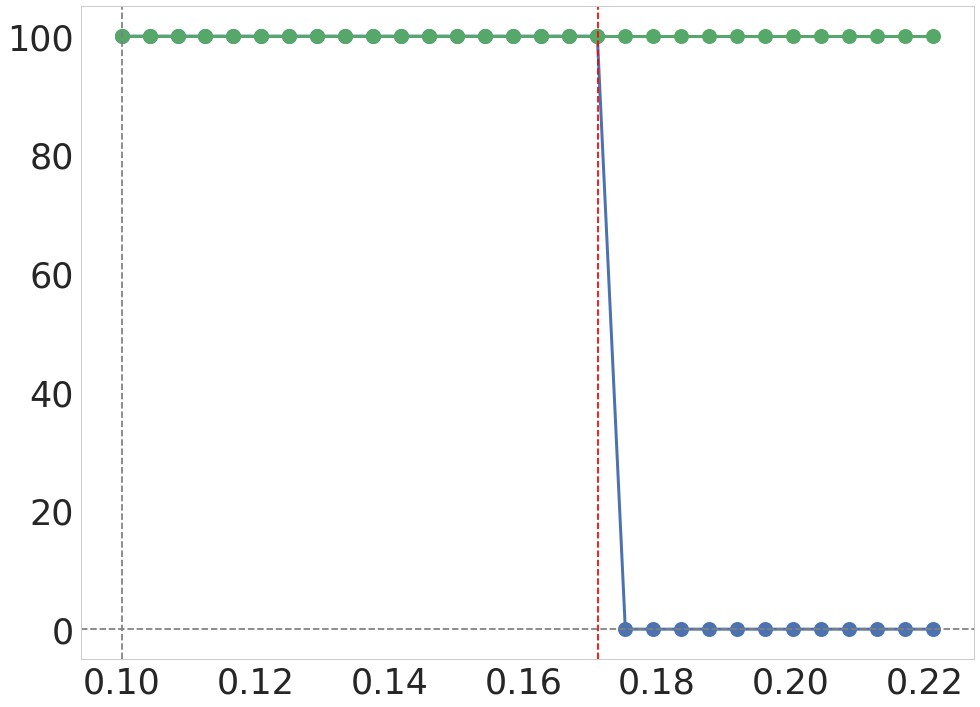

In [77]:
markersize = 15
linewidth = 3

plt.plot(Tn_space, successes, 'o-', markersize=markersize, lw=linewidth)
plt.plot(Tn_space, successes_s, 'o-', markersize=markersize, lw=linewidth)

plt.axhline(0, ls='--', color='gray')
plt.axvline(Tp, ls='--', color='gray')
plt.axvline(Tc, ls='--', color='red')

In [73]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Training times
Tp = 0.100
factor = tau_a * np.log(2.0 - np.exp(-Tp/tau_a))
Tc = Tp + factor

num = 30
Tn_space = np.linspace(Tp, Tc + 0.050, num=num)
successes_m = np.zeros(num)

# Matrix parameters
w_rest = -1.0
w_self = 1.0
w_next = []
symmetric = True
index_p = 5

# Recall
patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

training_time = [Tp for i in range(n_patterns)]

for index, Tn in enumerate(Tn_space):
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    training_time[index_p] = Tn
    # Print
    
    # Build the matrix
    w_next = []
    for T in training_time:
        w_diff = 1 - np.exp(- T/ tau_a)
        w_next.append(w_self - w_diff)
    w = np.ones((minicolumns, minicolumns)) * w_rest
    for i in range(n_patterns):
        w[i, i] = w_self
        if i < minicolumns - 1:
            w[i + 1, i] = w_next[i]
            w[i - 1, i] = w_next[i]
    
    # Symmetric
    if symmetric:
        w[index_p - 1, index_p] = w_next[1]
    else:
        w[index_p - 1, index_p] = 10e-10
    
    # Add the matrix
    nn.w_ampa = w
    
    # Run the network
    T_cue = 0.020
    T_recall = Tn + Tp * n_patterns +  T_cue
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    successes_m[index] = success

CPU times: user 10.2 s, sys: 16 ms, total: 10.3 s
Wall time: 10.2 s


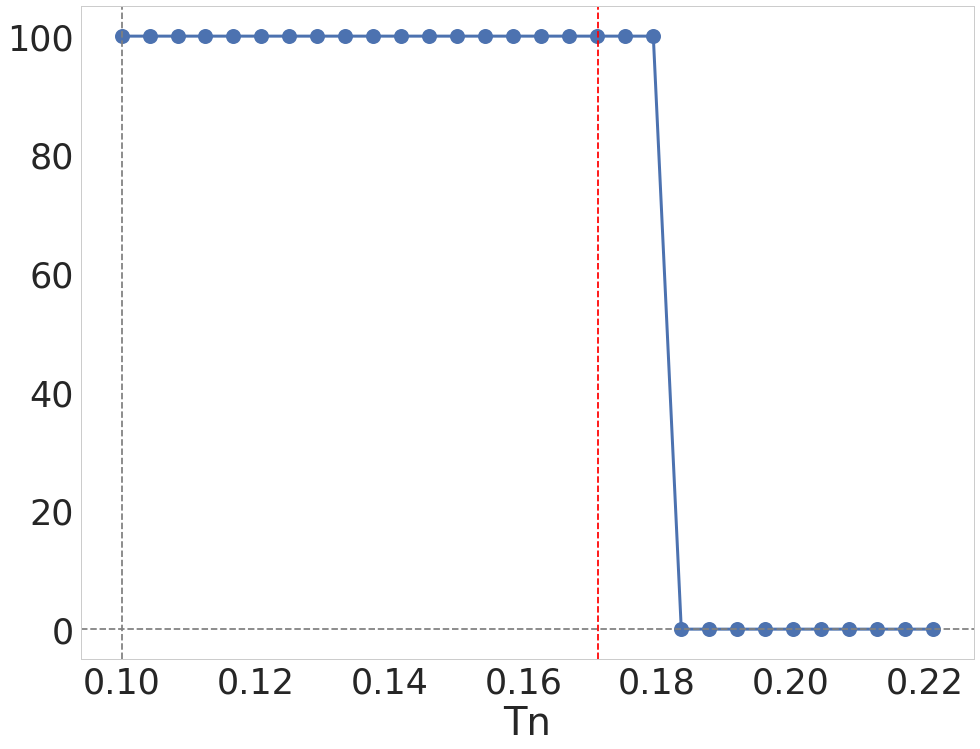

In [75]:
markersize = 15
linewidth = 3

plt.plot(Tn_space, successes_m, 'o-', markersize=markersize, lw=linewidth)
plt.axhline(0, ls='--', color='gray')
plt.axvline(Tp, ls='--', color='gray')
plt.axvline(Tc, ls='--', color='red')

plt.xlabel('Tn')

## Why the linear term on tau_a

In [7]:
Tp = 0.100
tau_a_list  = [0.050, 0.100, 0.150, 0.250]
Tt = 2 * Tp
t = np.linspace(0, Tt, num=1000)
f_list = []
for tau_a in tau_a_list:
    f = (1 - np.exp(-Tp / tau_a)) * np.exp(-t / tau_a)
    f_list.append(f)


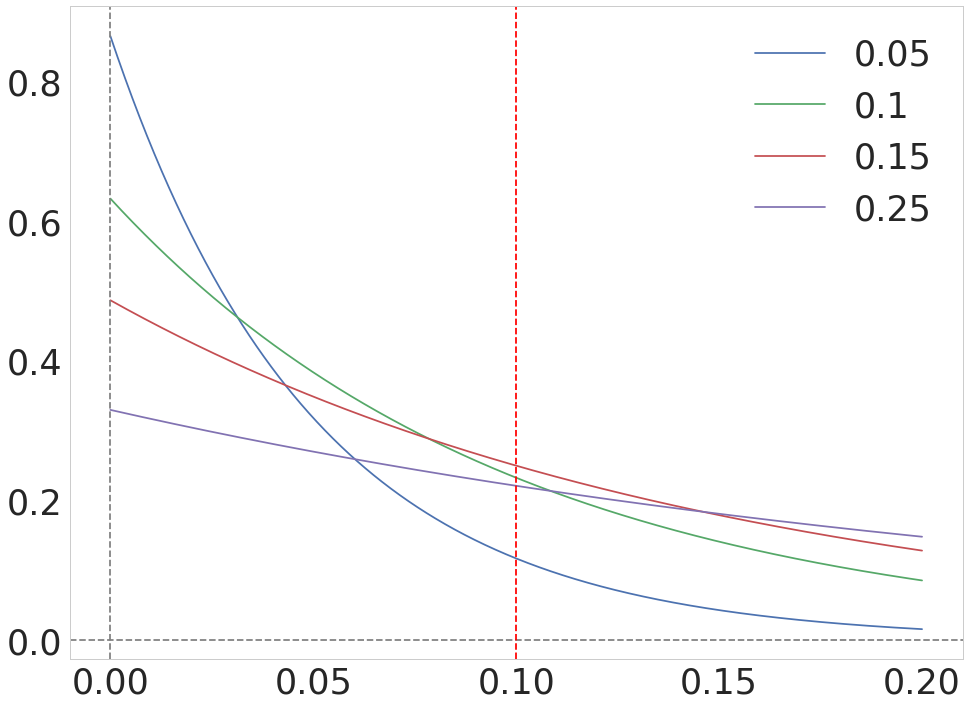

In [11]:
for tau_a, f in zip(tau_a_list, f_list):
    plt.plot(t, f, label=str(tau_a))

plt.legend()
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')
plt.axvline(Tp, ls='--', color='red', label='Tp')

## Factor

In [15]:
Tp_list = [0.050, 0.100, 0.150, 0.500, 1.0]
tau_a = np.linspace(0.50, 1.0, num=100)

factor_list = []
for Tp in Tp_list:
    factor = tau_a * np.log(2 - np.exp(-Tp/tau_a))
    factor_list.append(factor)

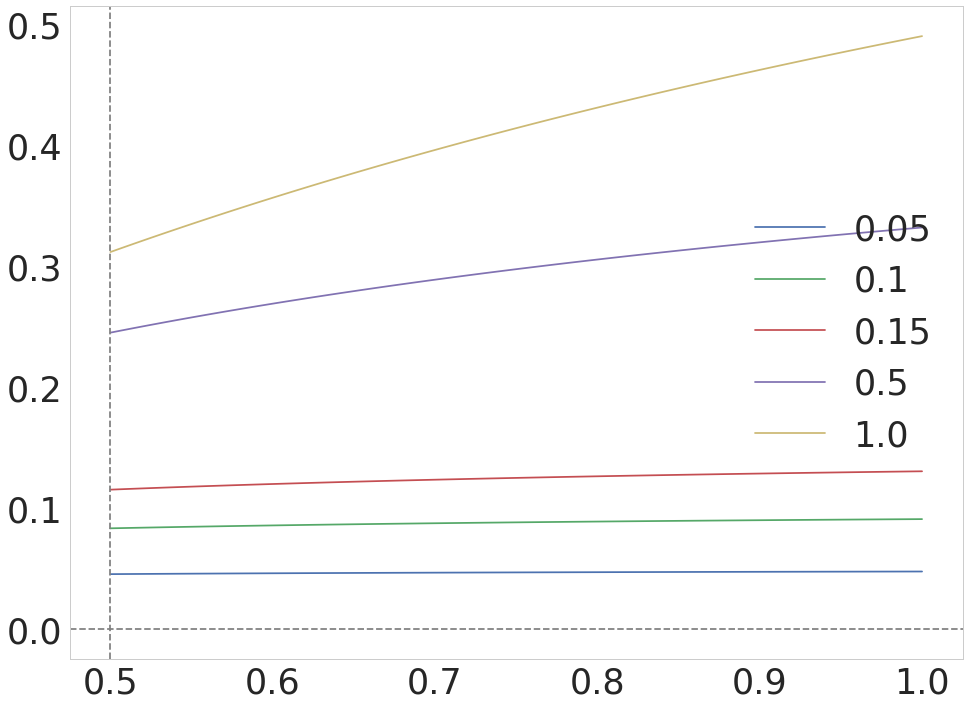

In [16]:
for Tp, factor in zip(Tp_list, factor_list):
    plt.plot(tau_a, factor, label=str(Tp))

plt.axhline(0, ls='--', color='gray')
plt.axvline(tau_a[0], ls='--', color='gray')
plt.xlabel('tau_a')
plt.ylabel('factor')
plt.legend();

## Weight difference 

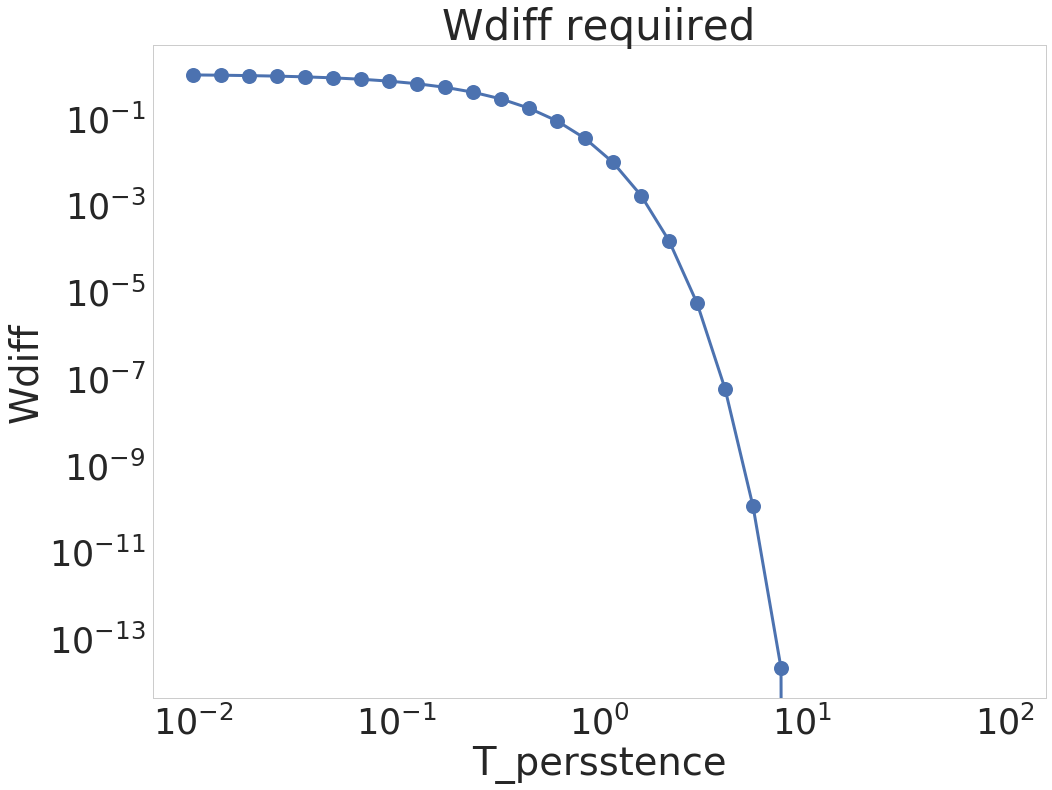

In [81]:
markersize = 15
linewidth = 3

num = 30
tau_a = 0.250
T = np.logspace(-2, 2, num=num)
w_self = 1.0
w_diff = 1 - np.exp(-T / tau_a)
w_next = w_self - w_diff

plt.plot(T, w_next, 'o-', markersize=markersize, lw=linewidth)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('T_persstence')
plt.ylabel('Wdiff')
plt.title('Wdiff requiired')


## Assymetric filters

In [85]:
epsilon = 1e-20

In [113]:
%%time
num = 30
tau_z_pre_vector = np.linspace(0.005, 0.150, num=num)

# First we run the training protocol
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
# tau_z_post_ampa = tau_z_pre_ampa

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

Tt = 0.100

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
training_time = np.linspace(0.100, 1.500, num=n_patterns)
training_time = [Tt for i in range(n_patterns)]

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

to_index = 4
from_index = 3

w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_prev_vector = np.zeros(num)
w_rest_vector = np.zeros(num)


for index_z, tau_z_pre_ampa in enumerate(tau_z_pre_vector):

    timed_input = TimedInput(network_representation, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)


    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)
    
    w_self_vector[index_z] = w_timed[from_index, from_index]
    w_next_vector[index_z] = w_timed[to_index, from_index]
    w_prev_vector[index_z] = w_timed[from_index - 1, from_index]
    w_rest_vector[index_z] = w_timed[to_index + 1, from_index]


CPU times: user 1.2 s, sys: 12 ms, total: 1.22 s
Wall time: 1.21 s


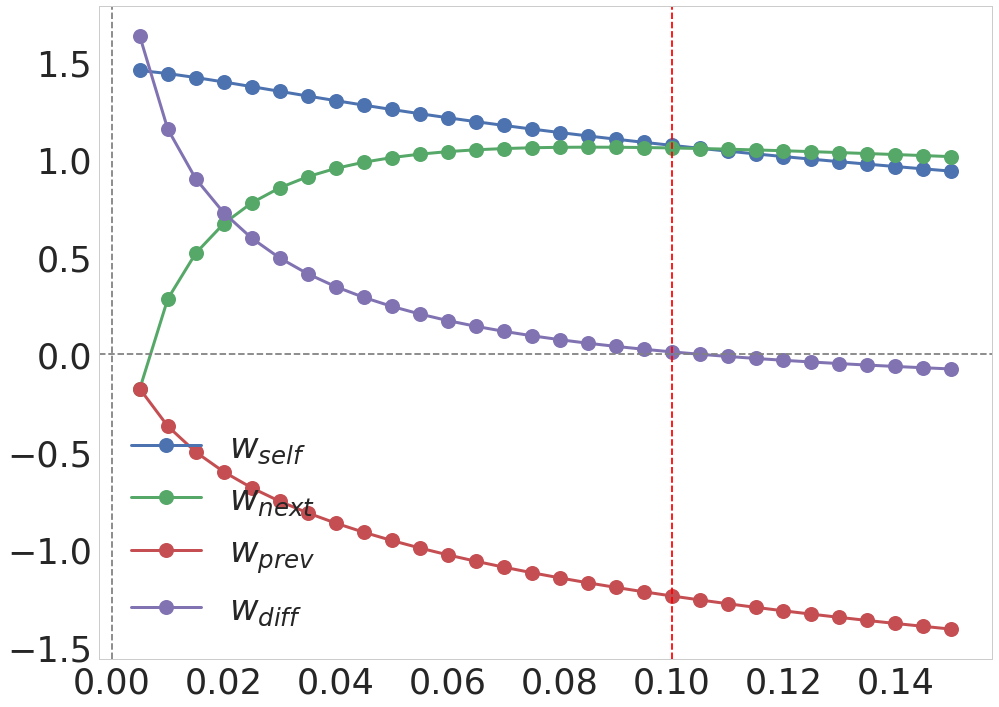

In [114]:
w_diff = w_self_vector - w_next_vector

plt.plot(tau_z_pre_vector, w_self_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{self}$')
plt.plot(tau_z_pre_vector, w_next_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{next}$')
plt.plot(tau_z_pre_vector, w_prev_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{prev}$')
#plt.plot(tau_z_pre_vector, w_rest_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{prev}$')
plt.plot(tau_z_pre_vector, w_diff, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{diff}$')


plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')
plt.axvline(.100, ls='--', color='red')

plt.legend();


In [104]:
%%time
# First we run the training protocol
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
# tau_z_post_ampa = tau_z_pre_ampa

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

Tt = 0.100

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
training_time = np.linspace(0.100, 1.500, num=n_patterns)
training_time = [Tt for i in range(n_patterns)]

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

to_index = 4
from_index = 3

num = 30
training_time_vector = np.linspace(0.010, 1.0, num=num)

w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_prev_vector = np.zeros(num)
w_rest_vector = np.zeros(num)


for index_t, training_time in enumerate(training_time_vector):

    timed_input = TimedInput(network_representation, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)


    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)
    
    w_self_vector[index_t] = w_timed[from_index, from_index]
    w_next_vector[index_t] = w_timed[to_index, from_index]
    w_prev_vector[index_t] = w_timed[from_index - 1, from_index]
    w_rest_vector[index_t] = w_timed[to_index + 1, from_index]


CPU times: user 3.06 s, sys: 4 ms, total: 3.06 s
Wall time: 3.04 s


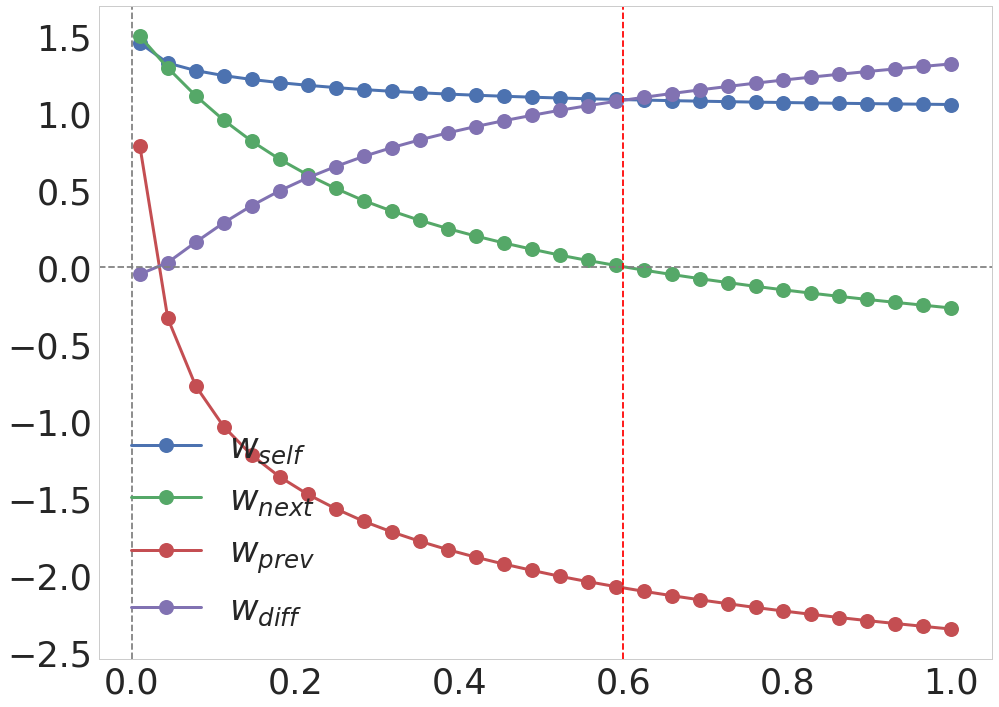

In [112]:
w_diff = w_self_vector - w_next_vector
plt.plot(training_time_vector, w_self_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{self}$')
plt.plot(training_time_vector, w_next_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{next}$')
plt.plot(training_time_vector, w_prev_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{prev}$')
plt.plot(training_time_vector, w_diff, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{diff}$')
#plt.plot(tau_z_pre_vector, w_rest_vector, 'o-', markersize=markersize, lw=linewidth, label=r'$w_{prev}$')


plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')
plt.axvline(.600, ls='--', color='red')

plt.legend();